In [1]:
from __future__ import print_function
import numpy as np
import torch
import torch.autograd as ag
import mnist_reader
import MNISTtools
import matplotlib.pyplot as plt
import time

In [2]:
xtrain, ltrain = mnist_reader.load_mnist('data/data/fashion', kind='train')
xtest, ltest = mnist_reader.load_mnist('data/data/fashion', kind='t10k')
xtrain, xtest = xtrain.T, xtest.T

In [3]:
print('xtrain shape: ',xtrain.shape)
print('xtest.shape: ',xtest.shape)
print('ltrain.shape: ',ltrain.shape)

xtrain shape:  (784, 60000)
xtest.shape:  (784, 10000)
ltrain.shape:  (60000,)


In [4]:
def normalize_MNIST_images(x):
    x=x.astype(np.float64)
    return (x*2/255.0)-1.0
    
xtrain=normalize_MNIST_images(xtrain)
xtest=normalize_MNIST_images(xtest)

22.

In [5]:
m,n=xtrain.shape
train=xtrain.T.reshape((n, 28, 28))
train=train[:,None,:,:]           # to add 1 dimension for channel
print(train.shape)
# train=np.moveaxis(train,2,-1)     # as it wants width x height

(60000, 1, 28, 28)


In [6]:
m,n=xtest.shape
test=xtest.T.reshape((n, 28, 28))
test=test[:,None,:,:]           # to add 1 dimension for channel
print(test.shape)
# test=np.moveaxis(test,2,-1)     # as it wants width x height

(10000, 1, 28, 28)


23.

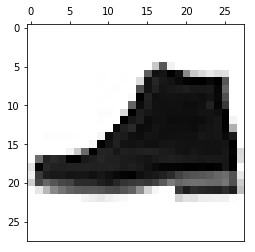

label is:  9


In [7]:
MNISTtools.show(train [42 , 0, :, :])
print('label is: ',ltrain[42])

24.

In [8]:
xtrain = ag.Variable( torch.from_numpy(train), requires_grad=False)
ltrain = ag.Variable( torch.from_numpy(ltrain).long(), requires_grad=False)
xtest = ag.Variable( torch.from_numpy(test), requires_grad = False)
ltest = ag.Variable( torch.from_numpy(ltest).long(), requires_grad = False)

if torch.cuda.is_available():
    xtrain = xtrain.cuda()
    ltrain = ltrain.cuda()
    xtest = xtest.cuda()
    ltest = ltest.cuda()

# Convolutional Neural Networks (CNN)

25.

(a) output after convolutional layer KxK = 5x5, C=6, ReLu and maxpooling: N x 6 x (28-5+1)/2 x (28-5+1)/2  
N x 6 x 12 x 12. Lets ignore N (total images). then it is 6x12x12.

(b) output after convolutional layer KxK = 5x5, C=16, ReLu and maxpooling: 16 x (12-5+1)/2 x (12-5+1)/2  
16 x 4 x 4      (ignoring N)

Third layer has 16x4x4 = 256 input units

26.

In [9]:
import torch.nn as nn
import torch.nn.functional as F
# This is our neural networks class that inherits from nn.Module
class LeNet(nn.Module):
    # Here we define our network structure
    def __init__(self):
        super(LeNet , self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5).double()
        self.conv2 = nn.Conv2d(6, 16, 5).double()
        self.fc1 = nn.Linear(256 , 120).double()
        self.fc2 = nn.Linear(120 , 84).double()
        self.fc3 = nn.Linear(84 , 10).double()
        
    # Here we define one forward pass through the network
    def forward(self , x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    # Determine the number of features in a batch of tensors
    def num_flat_features(self , x):
        size = x.size()[1:]
        return np.prod(size)

if torch.cuda.is_available():
    net = LeNet().cuda()
else:
    net = LeNet()
print(net)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


27.

In [10]:
# params = list(net.parameters())
# for i in range(len(params)):       # prints out weights and biases for each layer
#     print(i, params[i].size())

28.

In [11]:
def performance(pred, labels):
    return (100 * np.mean(labels == pred.data.numpy().T.argmax(axis=0)))

def performance_using_gpu(pred, labels):
    max_index = pred.max(dim = 1)[1]
    acc = (max_index==labels).float().sum()/max_index.size()[0]
    return 100*acc.cpu().data.numpy()[0]

In [12]:
yinit = net(xtest)
# if torch.cuda.is_available():
#     yinit = yinit.cpu()
#     labels = ltest.cpu().data.numpy()
print(performance_using_gpu(yinit, ltest))

17.430000007152557


In [13]:
# print(yinit[0])
# print(ltest[0])

29.

In [14]:
N = xtrain.size()[0] # Training set size
B = 100 # Minibacth size
NB = int(np.ceil(N/B)) # Number of minibatches
T = 10 # Number of epochs
gamma = .001 # learning rate
rho = .9 # momentum
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = gamma , momentum = rho )
# PyTorch’s CrossEntropyLoss is the composition of a softmax activation with the standard cross-entropy loss.

30.

In [15]:
# if torch.cuda.is_available():
#     ltrain=ltrain.cpu()
def train_net(net, xtrain, ltrain, T=10, validation=False):
    start=time.time()
    N = xtrain.size()[0] # Training set size
    #B = 100 # Minibacth size
    cv_acc, test_acc = [],[]
    cv_losses, test_losses = [],[]
    train_losses=[]
    if validation:
        idx=np.arange(N)
        np.random.shuffle(idx)
        cv_xtrain=xtrain[idx[0:int(0.1*N)]]
        cv_ltrain=ltrain[idx[0:int(0.1*N)]]
        xtrain=xtrain[idx[int(0.1*N):N]]
        ltrain=ltrain[idx[int(0.1*N):N]]
        # print('xtrain: ',len(xtrain))
        # print('ltrain: ',len(cv_ltrain))
        N=len(xtrain)
        
    NB = int(np.ceil(N/B)) # Number of minibatches
    # T = 20 # Number of epochs
    #gamma = .001 # learning rate
    #rho = .9 # momentum
    #criterion = nn.CrossEntropyLoss()
    #optimizer = torch.optim.SGD(net.parameters(), lr = gamma , momentum = rho )
    metrics={}
    train_loss=0.0
    for epoch in range(T):
        running_loss = 0.0
        idxminibatches = np.random.permutation(NB) # shuffling
        running_loss = 0.0
        for k in range(NB):
            i = idxminibatches[k] # index of minibatch
            # Extract i-th minibatch from xtrain and ltrain
            idxsmp = np.arange(B*i, min(B*(i+1), N)) # indices of samples for i-th minibatch
            inputs,labels = xtrain[idxsmp], ltrain[idxsmp]
            
            optimizer.zero_grad()                 # Initialize the gradients to zero
            outputs = net(inputs)                 # Forward propagation
            loss = criterion(outputs , labels )   # Error evaluation
            loss.backward()                       # Back propagation
            optimizer.step()                      # Parameter update
            
            # Print averaged loss per minibatch every 100 mini - batches
            running_loss += loss [0]
            #if k % 500 == 499:
            #    print ('[%d, %5d]  loss : %.3f'%( epoch + 1, k + 1, running_loss/500 ))
            #    running_loss = 0.0
        if validation and epoch%5==4 :
            predsCuda = net(cv_xtrain)
            cv_acc.append( performance_using_gpu(predsCuda, cv_ltrain) )
            cv_losses.append(criterion(predsCuda , cv_ltrain )[0].cpu().data.numpy()[0] )
            
            predsCuda = net(xtest)
            acc = performance_using_gpu(predsCuda, ltest)
            test_acc.append( acc )
            test_losses.append( criterion(predsCuda , ltest )[0].cpu().data.numpy()[0] )
            train_losses.append((running_loss/NB).cpu().data.numpy()[0])
            print ('%d  test_acc : %.3f'%( epoch + 1, acc))
            
    metrics['cv_acc'], metrics['cv_losses'] = cv_acc,cv_losses
    metrics['test_acc'], metrics['test_losses'] = test_acc,test_losses
    metrics['train_losses'] = train_losses
    print('Total time taken in training (secs): ',time.time()-start)
    return net, metrics

# Baseline (with given hyperparamerters)

In [16]:
if torch.cuda.is_available():
    net = LeNet().cuda()
else:
    net = LeNet()
    
B = 100          # Minibacth size
gamma = .001     # learning rate
rho = .9         # momentum
T=200            # epochs
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = gamma , momentum = rho )

net, metrics = train_net(net, xtrain, ltrain, T, validation=True)
print('Finished Training')

5  test_acc : 76.410
10  test_acc : 82.070
15  test_acc : 84.700
20  test_acc : 84.620
25  test_acc : 86.060
30  test_acc : 86.750
35  test_acc : 87.970
40  test_acc : 88.390
45  test_acc : 88.880
50  test_acc : 89.280
55  test_acc : 88.810
60  test_acc : 89.420
65  test_acc : 89.060
70  test_acc : 89.580
75  test_acc : 89.360
80  test_acc : 89.100
85  test_acc : 89.930
90  test_acc : 89.140
95  test_acc : 88.930
100  test_acc : 89.060
105  test_acc : 89.650
110  test_acc : 89.120
115  test_acc : 90.040
120  test_acc : 89.530
125  test_acc : 89.850
130  test_acc : 89.990
135  test_acc : 89.650
140  test_acc : 89.920
145  test_acc : 89.570
150  test_acc : 89.680
155  test_acc : 89.070
160  test_acc : 89.360
165  test_acc : 89.440
170  test_acc : 89.490
175  test_acc : 89.490
180  test_acc : 89.880
185  test_acc : 89.730
190  test_acc : 88.990
195  test_acc : 89.420
200  test_acc : 89.640
Total time taken in training (secs):  400.814958096
Finished Training


# Plot training metrics

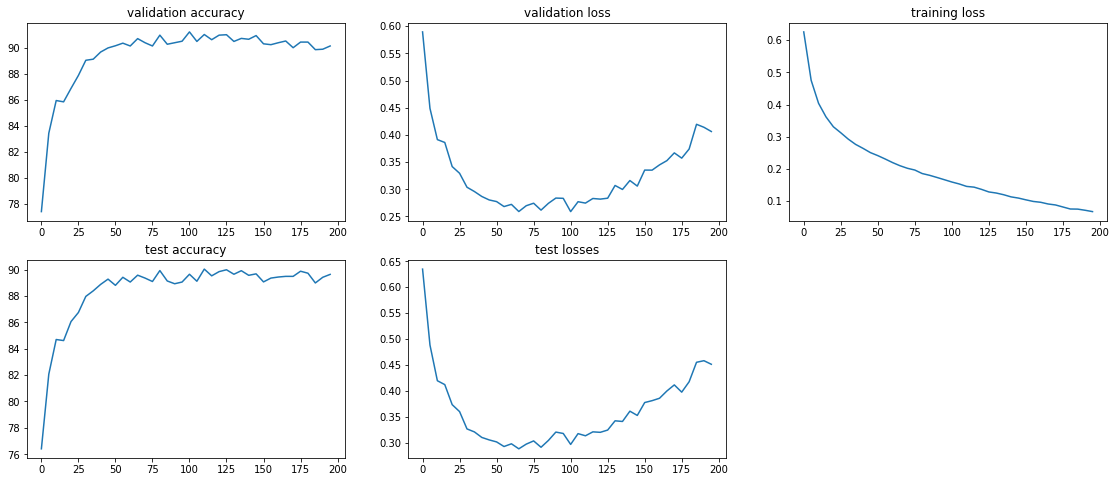

In [20]:
def plot_metrics(metrics):
    xlimits=range(0,T,5)
    plt.figure(figsize=(8,8))
    i=1
    metrics_keys = ['cv_acc','cv_losses','train_losses','test_acc','test_losses']
    titles = ['validation accuracy', 'validation loss', 'training loss',\
             'test accuracy', 'test losses']
    for metric,title in zip(metrics_keys, titles):
        plt.subplot(2,3,i)
        plt.plot(xlimits, metrics[metric])
        plt.title(title)
        i+=1
    plt.subplots_adjust(right=2)
    fig=plt.gcf()               # store the plot to store it later
    plt.show()
    return fig
        
fig=plot_metrics(metrics)

In [21]:
t=str(time.strftime("%c"))
fig.savefig('plots/'+ 'baseline result __ '+ t +'.jpg', bbox_inches='tight')

# Test metrics

In [22]:
predsCuda = net(xtest)
if torch.cuda.is_available():
    pred = predsCuda.cpu()
    labels = ltest.cpu().data.numpy()
print(performance(pred, labels))
print(performance_using_gpu(predsCuda, ltest))

89.64
89.6399974822998


# Experiment hyperparameters and optimizations

In [42]:
if torch.cuda.is_available():
    net = LeNet().cuda()
else:
    net = LeNet()
    
B = 100          # Minibacth size
gamma = .001     # learning rate
rho = 0.9         # momentum
T=200            # epochs
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = gamma , momentum = rho )

net, metrics = train_net(net, xtrain, ltrain, T, validation=True)
print('Finished Training')

5  test_acc : 68.820
10  test_acc : 74.180
15  test_acc : 77.250
20  test_acc : 78.850
25  test_acc : 80.140
30  test_acc : 81.880
35  test_acc : 83.300
40  test_acc : 83.440
45  test_acc : 84.640
50  test_acc : 84.420
55  test_acc : 85.290
60  test_acc : 85.980
65  test_acc : 85.830
70  test_acc : 86.350
75  test_acc : 86.470
80  test_acc : 86.980
85  test_acc : 87.190
90  test_acc : 87.210
95  test_acc : 87.330
100  test_acc : 87.440
105  test_acc : 87.570
110  test_acc : 87.840
115  test_acc : 87.800
120  test_acc : 87.710
125  test_acc : 87.830
130  test_acc : 87.750
135  test_acc : 88.360
140  test_acc : 88.360
145  test_acc : 88.700
150  test_acc : 88.760
155  test_acc : 88.410
160  test_acc : 88.590
165  test_acc : 88.910
170  test_acc : 88.560
175  test_acc : 88.850
180  test_acc : 88.600
185  test_acc : 88.850
190  test_acc : 88.890
195  test_acc : 89.260
200  test_acc : 88.860
205  test_acc : 89.160
210  test_acc : 89.340
215  test_acc : 89.240
220  test_acc : 89.550
225  tes

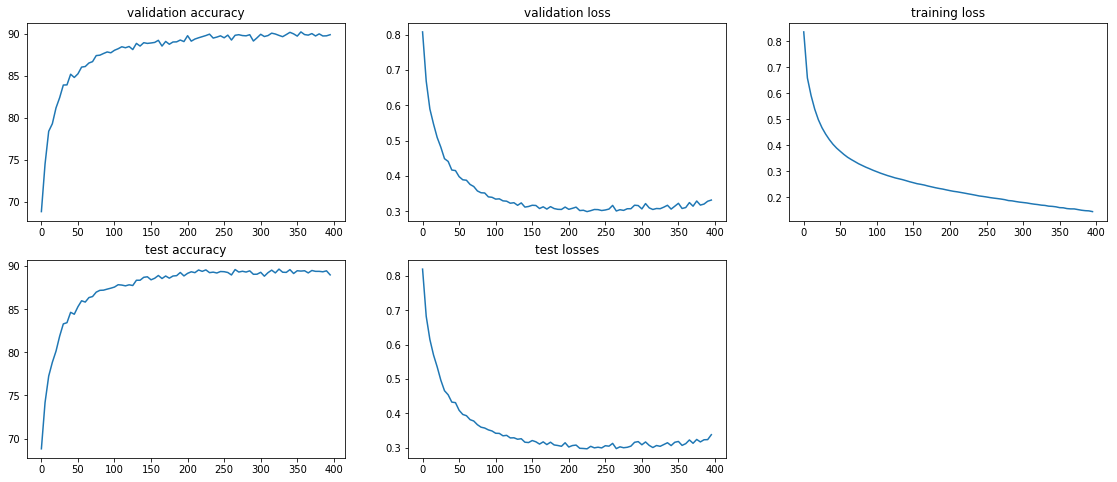

In [44]:
fig=plot_metrics(metrics)
t=str(time.strftime("%c"))
fig.savefig('plots/'+ 'momentum = 0,6 T=400 __ '+ t +'.jpg', bbox_inches='tight')

In [28]:
print(len(ltrain))

60000
